In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Data Import and Preprocessing

In [2]:
#Import data

churn_df = pd.read_csv('churn_data.csv')

churn_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [3]:
#Remove columns that are not useful such as all of them are unique or only with single value (if any)

single_val_col = [col for col in churn_df.columns if churn_df[col].unique().size==1]
single_val_col

all_dif_val_col = [col for col in churn_df.columns if churn_df[col].unique().size==len(churn_df)]
all_dif_val_col

churn_df.drop(single_val_col+all_dif_val_col, axis=1, inplace=True)

In [4]:
#Check for missing values and weird values

churn_df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
[(col, churn_df[col].unique()) for col in churn_df.columns]

[('gender', array(['Female', 'Male'], dtype=object)),
 ('SeniorCitizen', array([0, 1], dtype=int64)),
 ('Partner', array(['Yes', 'No'], dtype=object)),
 ('Dependents', array(['No', 'Yes'], dtype=object)),
 ('tenure',
  array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
         21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
          9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
         36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
         54, 51, 26,  0, 39], dtype=int64)),
 ('PhoneService', array(['No', 'Yes'], dtype=object)),
 ('MultipleLines', array(['No phone service', 'No', 'Yes'], dtype=object)),
 ('InternetService', array(['DSL', 'Fiber optic', 'No'], dtype=object)),
 ('OnlineSecurity', array(['No', 'Yes', 'No internet service'], dtype=object)),
 ('OnlineBackup', array(['Yes', 'No', 'No internet service'], dtype=object)),
 ('DeviceProtection',
  array(['No', 'Yes', 'No internet service'], 

In [6]:
#As column 'TotalCharges' looks sketchy for a supposed-to-be numeric type to be object type, it is investigated further

pd.to_numeric(churn_df['TotalCharges'])

ValueError: Unable to parse string " " at position 488

In [7]:
#Check if there are too many missing values for 'TotalCharges'

print('Number of rows with missing values: '+str(len(churn_df.loc[churn_df['TotalCharges']==' '])))

churn_df.loc[churn_df['TotalCharges']==' ']

Number of rows with missing values: 11


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [8]:
#Replace the missing values with 0 and check by using column 'Tenure' and change the type to numeric

churn_df.loc[churn_df['TotalCharges']==' ','TotalCharges'] = 0

churn_df.loc[churn_df['tenure']==0]

churn_df['TotalCharges'] = pd.to_numeric(churn_df['TotalCharges'])

churn_df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [9]:
#In order to draw a XGBoost tree, there should be no empty space

churn_df.replace(' ', '_', regex=True, inplace=True)
churn_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes


# Exploratory Data Analysis

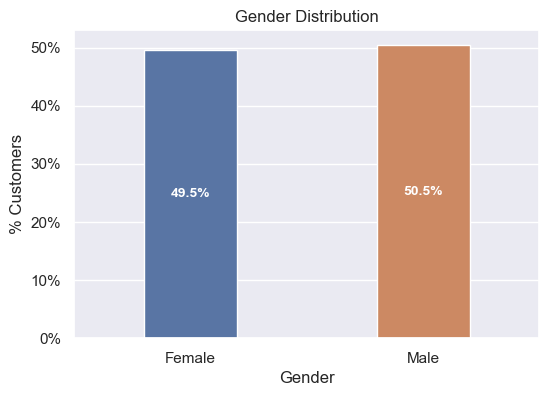

In [10]:
#Gender is balanced

sns.set_theme()
sns.color_palette('deep')

plt.figure(figsize=(6,4))

ax = sns.countplot(x=churn_df['gender'], stat='percent', width=0.4, hue=churn_df['gender'])

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers')
ax.set_xlabel('Gender')
ax.set_title('Gender Distribution')

for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', label_type='center', color='white', weight='bold', fontsize=10)

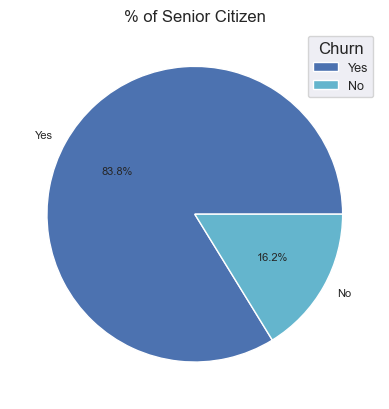

In [11]:
#Most of the customers in the dataset is senior citizen

cmap = ListedColormap(sns.color_palette('deep'))

ax = (churn_df['SeniorCitizen'].value_counts()*100/len(churn_df)) \
     .plot.pie(autopct='%.1f%%', labels=["Yes", "No"], fontsize=8, cmap=cmap)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel(None)
ax.set_title('% of Senior Citizen', fontsize=12)
ax.legend(title='Churn', fontsize=9)

Text(0.5, 1.0, '# of Customers by Tenure')

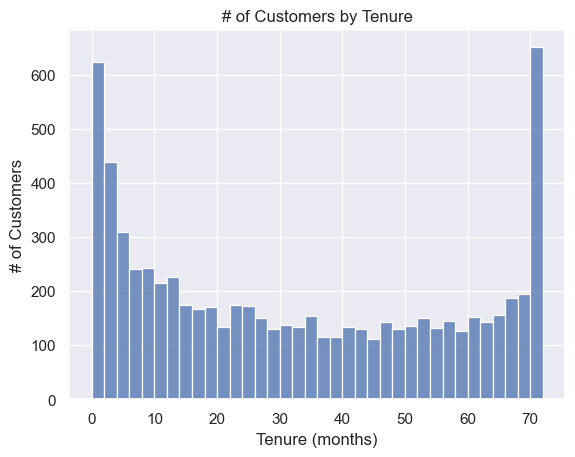

In [12]:
sns.histplot(churn_df['tenure'], bins=int(180/5))

plt.ylabel('# of Customers')
plt.xlabel('Tenure (months)')
plt.title('# of Customers by Tenure')

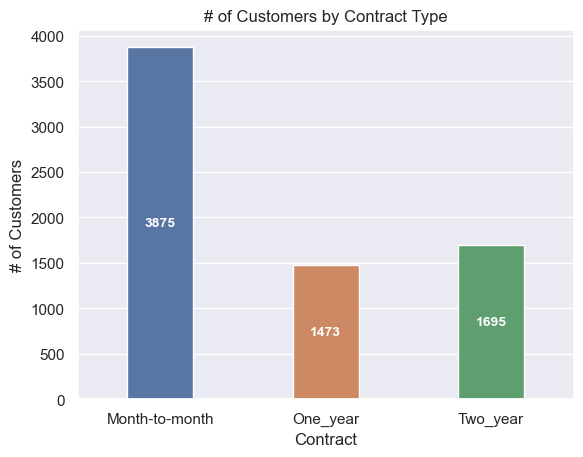

In [13]:
#Interestingly a lot of them are with monthly contract

ax = sns.countplot(x=churn_df['Contract'], width = 0.4, hue=churn_df['Contract'])

plt.ylabel('# of Customers')
plt.title('# of Customers by Contract Type')

for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='center', color='white', weight='bold', fontsize=10)

Text(0, 0.5, '# of Customers')

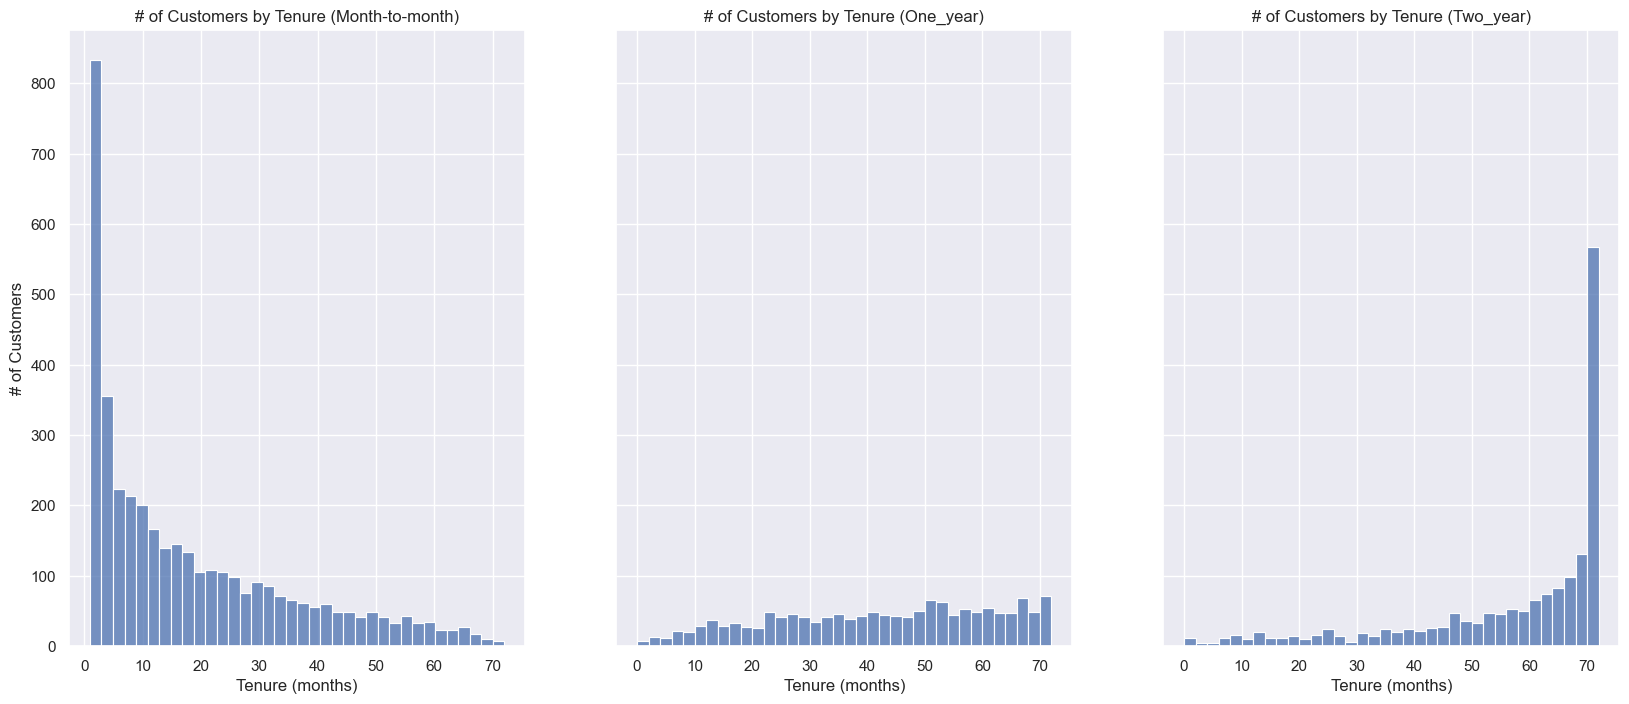

In [14]:
#Month to month contact seems to be less loyal (lower tenure)

fig, axes = plt.subplots(1, 3, figsize=(20,8), sharey=True, squeeze=False)

for i, v in enumerate(churn_df['Contract'].unique()):
    ax = axes[0][i]
    sns.histplot(x=churn_df[churn_df['Contract']==v]['tenure'], bins=int(180/5), ax=ax)
    axes[0][i].set_xlabel('Tenure (months)')
    axes[0][i].set_title('# of Customers by Tenure ({})'.format(v))
axes[0][0].set_ylabel('# of Customers')
    

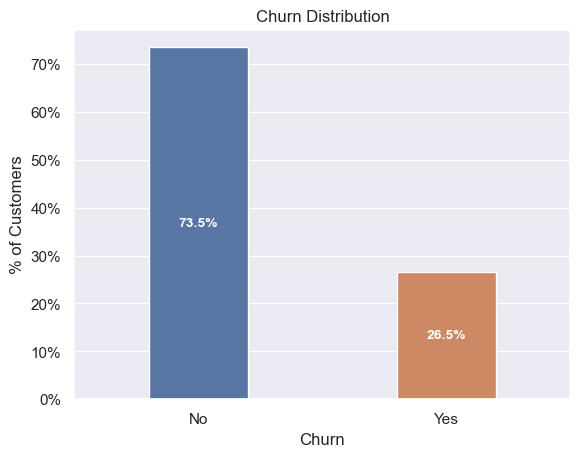

In [15]:
#An imbalanced dataset

ax = sns.countplot(x=churn_df['Churn'], stat='percent', width=0.4, hue=churn_df['Churn'])

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% of Customers')
ax.set_xlabel('Churn')
ax.set_title('Churn Distribution')

for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', label_type='center', color='white', weight='bold', fontsize=10)

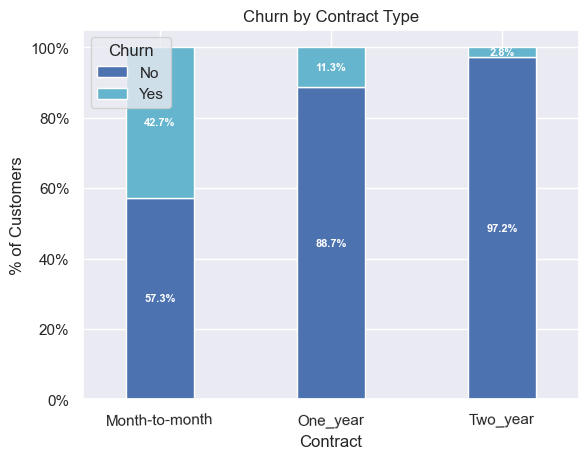

In [16]:
#It is very distinct now, with different contract type, the churn rate can be very different

contract_churn = churn_df.groupby(['Contract','Churn']).size().unstack()

ax = (contract_churn.T*100/contract_churn.T.sum()).T.plot(kind='bar', 
                                                          stacked=True,
                                                          rot=True,
                                                          width=0.4,
                                                          cmap=cmap)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best', title='Churn')
ax.set_ylabel('% of Customers')
ax.set_title('Churn by Contract Type')

for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', label_type='center', color='white', weight='bold', fontsize=8)

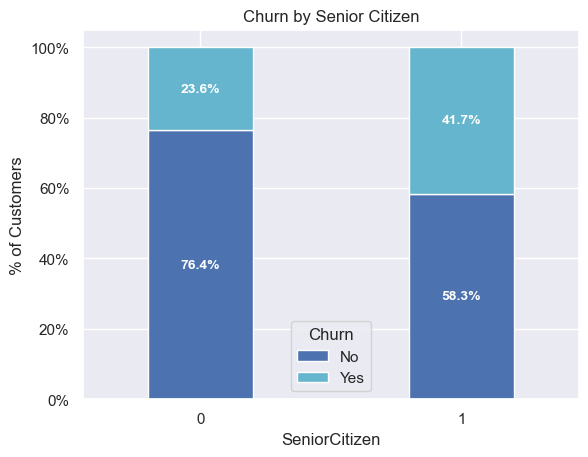

In [17]:
#Senior citizen is more possible to churn

senior_churn = churn_df.groupby(['SeniorCitizen','Churn']).size().unstack()

ax = (senior_churn.T*100/senior_churn.T.sum()).T.plot(kind='bar', 
                                                          stacked=True,
                                                          rot=True,
                                                          width=0.4,
                                                          cmap=cmap)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best', title='Churn')
ax.set_ylabel('% of Customers')
ax.set_title('Churn by Senior Citizen')

for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', label_type='center', color='white', weight='bold', fontsize=10)

C:\Users\Ben Leong\AppData\Local\Temp\ipykernel_11696\644470355.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(churn_df[churn_df['Churn']=='Yes']['MonthlyCharges'], shade=True)
C:\Users\Ben Leong\AppData\Local\Temp\ipykernel_11696\644470355.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(churn_df[churn_df['Churn']=='No']['MonthlyCharges'], shade=True)


Text(0.5, 1.0, 'Monthly Charge Distribution by Churn')

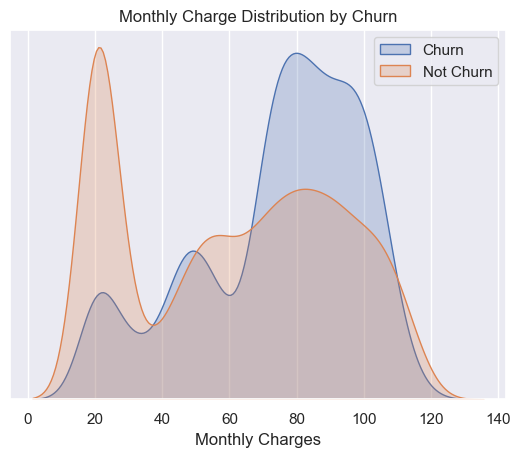

In [18]:
#More likely to churn when monthly charges is higher

sns.kdeplot(churn_df[churn_df['Churn']=='Yes']['MonthlyCharges'], shade=True)
sns.kdeplot(churn_df[churn_df['Churn']=='No']['MonthlyCharges'], shade=True)

plt.ylabel(None)
plt.yticks([])

plt.legend(['Churn','Not Churn'])
plt.xlabel('Monthly Charges')
plt.title('Monthly Charge Distribution by Churn')

C:\Users\Ben Leong\AppData\Local\Temp\ipykernel_11696\2944981983.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(churn_df[churn_df['Churn']=='Yes']['TotalCharges'], shade=True)
C:\Users\Ben Leong\AppData\Local\Temp\ipykernel_11696\2944981983.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(churn_df[churn_df['Churn']=='No']['TotalCharges'], shade=True)


Text(0.5, 1.0, 'Total Charge Distribution by Churn')

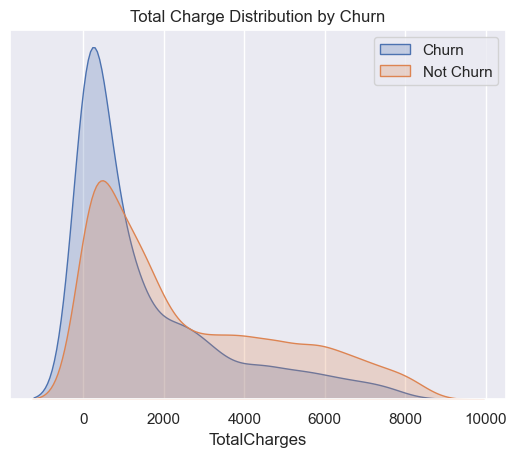

In [19]:
#Churn is only more possible when the total charges are low

sns.kdeplot(churn_df[churn_df['Churn']=='Yes']['TotalCharges'], shade=True)
sns.kdeplot(churn_df[churn_df['Churn']=='No']['TotalCharges'], shade=True)

plt.ylabel(None)
plt.yticks([])

plt.legend(['Churn','Not Churn'])
plt.title('Total Charge Distribution by Churn')

# Feature Transformation

In [20]:
churn_df['SeniorCitizen'] = churn_df['SeniorCitizen'].apply(lambda x: 'Yes' if x==1 else 'No')

X = churn_df.drop(['Churn'], axis=1).copy()

X

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,No,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
3,Male,No,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75
4,Female,No,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One_year,Yes,Mailed_check,84.80,1990.50
7039,Female,No,Yes,Yes,72,Yes,Yes,Fiber_optic,No,Yes,Yes,No,Yes,Yes,One_year,Yes,Credit_card_(automatic),103.20,7362.90
7040,Female,No,Yes,Yes,11,No,No_phone_service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic_check,29.60,346.45
7041,Male,Yes,Yes,No,4,Yes,Yes,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed_check,74.40,306.60


In [21]:
#Transform outcome variable to numeric
y = churn_df['Churn'].copy().apply(lambda x: 1 if x=='Yes' else 0)

y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

In [22]:
#Stratify to tackle imbalanced dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [23]:
cat_transformer = Pipeline(steps=[('one_hot',OneHotEncoder())])
num_transformer = Pipeline(steps=[('normalize',StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('cat_transformer',cat_transformer,[col for col in X.columns if X[col].dtypes=='object']),
                                               ('num_transformer',num_transformer,[col for col in X.columns if X[col].dtypes!='object'])])

logreg = Pipeline(steps=[('preprocessor',preprocessor),
                         ('Logistic Regression',LogisticRegression())])

SVM = Pipeline(steps=[('preprocessor',preprocessor),
                      ('SVM',SVC(kernel='linear'))])

RF = Pipeline(steps=[('preprocessor',preprocessor),
                     ('Random Forest',RandomForestClassifier())])

AdaBoost = Pipeline(steps=[('preprocessor',preprocessor),
                           ('Ada Boost',AdaBoostClassifier())])

XGBoost = Pipeline(steps=[('preprocessor',preprocessor),
                          ('XG Boost',xgb.XGBClassifier())])

In [24]:
#Logistic Regression

logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)

metrics.accuracy_score(y_test, pred)

0.807495741056218

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'InternetService_Fiber_optic'),
  Text(1, 0, 'Contract_Month-to-month'),
  Text(2, 0, 'TotalCharges'),
  Text(3, 0, 'StreamingMovies_Yes'),
  Text(4, 0, 'StreamingTV_Yes'),
  Text(5, 0, 'OnlineSecurity_No'),
  Text(6, 0, 'PaymentMethod_Electronic_check'),
  Text(7, 0, 'TechSupport_No'),
  Text(8, 0, 'PaperlessBilling_Yes'),
  Text(9, 0, 'MultipleLines_Yes')])

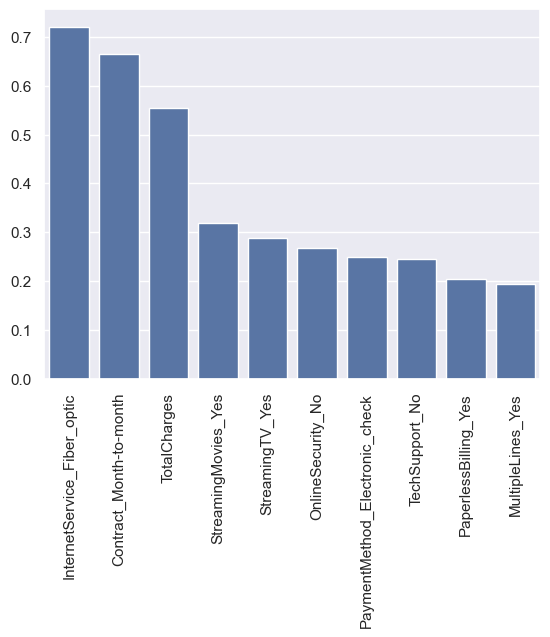

In [25]:
#Top10 variables that affect the customers to churn, interestingly, the faster the internet (fiber), the more likely they churn

logreg_coef = pd.Series(logreg[-1].coef_[0],
                        index=[name.split('__')[1] for name in logreg[:-1].get_feature_names_out()])

sns.barplot(logreg_coef.sort_values(ascending=False)[:10])
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'tenure'),
  Text(1, 0, 'Contract_Two_year'),
  Text(2, 0, 'MonthlyCharges'),
  Text(3, 0, 'InternetService_DSL'),
  Text(4, 0, 'PaperlessBilling_No'),
  Text(5, 0, 'InternetService_No'),
  Text(6, 0, 'TechSupport_No_internet_service'),
  Text(7, 0, 'StreamingMovies_No_internet_service'),
  Text(8, 0, 'DeviceProtection_No_internet_service'),
  Text(9, 0, 'OnlineBackup_No_internet_service')])

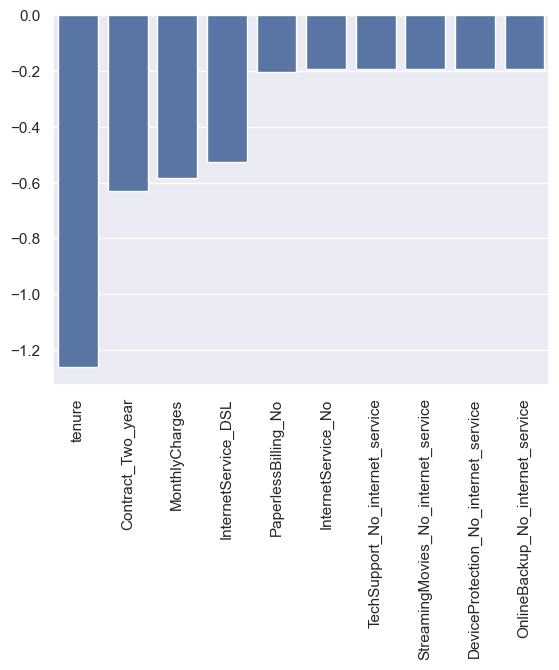

In [26]:
#As seen in EDA before, tenure and contract type does have negative impacts on the churn possibility

sns.barplot(logreg_coef.sort_values(ascending=True)[:10])
plt.xticks(rotation=90)

In [27]:
#Random Forest

RF.fit(X_train, y_train)
pred = RF.predict(X_test)

metrics.accuracy_score(y_test, pred)

0.7898921067575241

<Axes: >

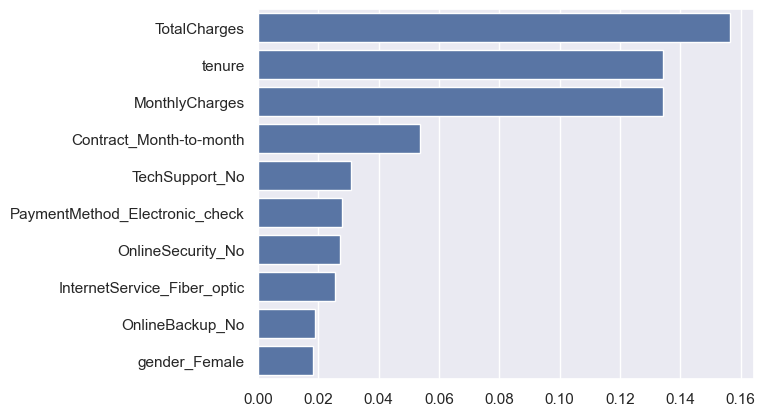

In [28]:
#Fairly similar results

RF_imp = pd.Series(RF[-1].feature_importances_,
                   index=[name.split('__')[1] for name in RF[:-1].get_feature_names_out()])

sns.barplot(RF_imp.sort_values(ascending=False)[:10],orient='h')

In [29]:
#SVM

SVM.fit(X_train, y_train)
pred = SVM.predict(X_test)

metrics.accuracy_score(y_test, pred)

0.7893242475865985

In [30]:
#Ada Boost
AdaBoost.fit(X_train, y_train)
pred = AdaBoost.predict(X_test)

metrics.accuracy_score(y_test, pred)

0.8001135718341851

In [31]:
#XG Boost
XGBoost.fit(X_train, y_train)
pred = XGBoost.predict(X_test)

metrics.accuracy_score(y_test, pred)

0.778534923339012

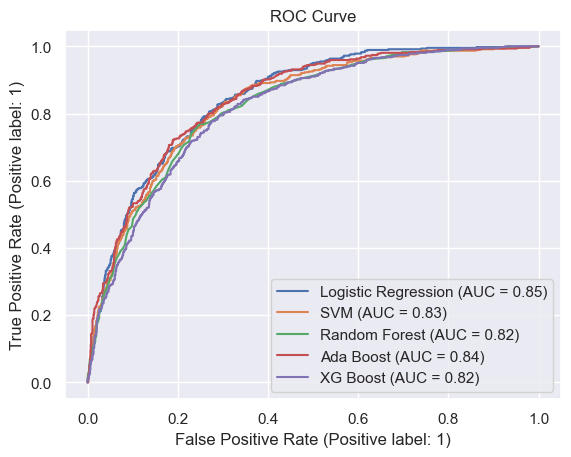

In [32]:
#ROC Comparison
#Logistic Regression is the best performing

fig, ax = plt.subplots()

MLModel = [
    ('Logistic Regression', logreg), 
    ('SVM', SVM),
    ('Random Forest', RF), 
    ('Ada Boost', AdaBoost),
    ('XG Boost', XGBoost)
]

model_display = {}
for name, pipeline in MLModel:
    model_display[name] = metrics.RocCurveDisplay.from_estimator(
        pipeline, X_test, y_test, ax=ax, name=name)
_ = ax.set_title('ROC Curve')

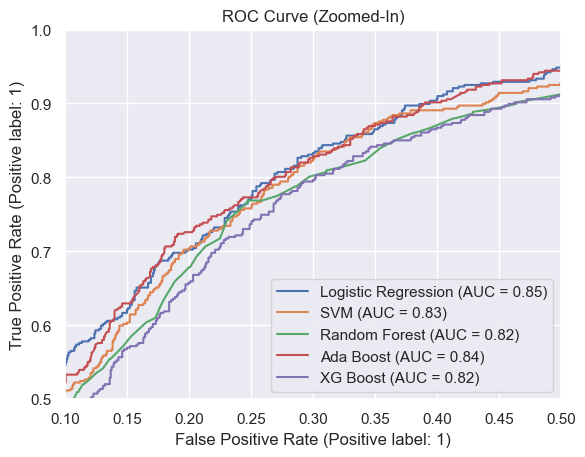

In [33]:
#Zoom into the ROC Curve

fig, ax = plt.subplots()
for name, pipeline in MLModel:
    model_display[name].plot(ax=ax)
    
ax.set_xlim(0.1, 0.5)
ax.set_ylim(0.5, 1)
_ = ax.set_title('ROC Curve (Zoomed-In)')

# XG Boost

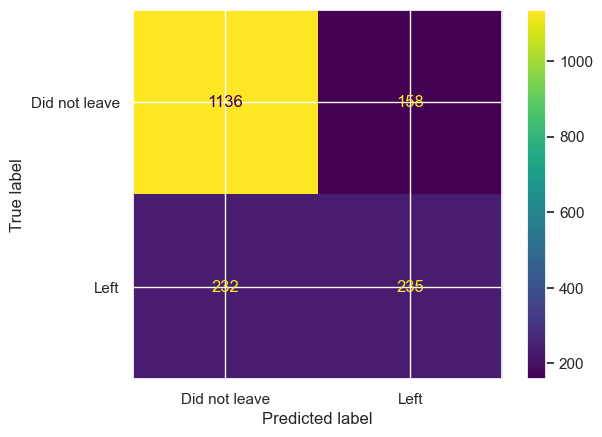

In [34]:
#Prediction evaluation

pred = XGBoost.predict(X_test)

cm = confusion_matrix(y_test, pred, labels=XGBoost[-1].classes_)

ConfusionMatrixDisplay(cm, 
                       display_labels=['Did not leave', 'Left']).plot()

In [39]:
##Hyperparameter tuning and minority prediction ('left') focusing
#Round 1

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5]
}

In [40]:
#Train with 90% of the random dataset and 50% random set of features to speed up efficiency

xg_model_cv = Pipeline(steps=[('preprocessor', preprocessor),
                               ('xgboost_cv', xgb.XGBClassifier(objective='binary:logistic',
                                                                 seed=42,
                                                                 subsample=0.9,
                                                                 colsample_bytree=0.5))])

X_train_transformed = xg_model_cv[:-1].fit_transform(X_train)
X_test_transformed = xg_model_cv[:-1].transform(X_test)

GSCV1 = GridSearchCV(estimator=xg_model_cv[-1], 
                     param_grid=param_grid, 
                     scoring='roc_auc',
                     verbose=0,
                     n_jobs=10,
                     cv=5)

In [41]:
GSCV1.fit(X_train_transformed, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'gamma': [0, 0.25, 1.0],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 4, 5, 6],
                         'reg_lambda': [0, 1.0, 10.0],
                         'scale_pos_weight': [1, 3, 5]},
             scoring='roc_auc')

In [42]:
print('1st Round Grid Search Best Parameters: {}'.format(GSCV1.best_params_))
print('1st Round Grid Search Best Score: {}'.format(GSCV1.best_score_))

1st Round Grid Search Best Parameters: {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 10.0, 'scale_pos_weight': 1}
1st Round Grid Search Best Score: 0.8484415487633582


In [43]:
#Round 2

'''
As implementing CV at once uses too much time, a 2nd round is proposed based on the chosen parameters.
''' 

param_grid={
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.1, 0.2, 0.5],
    'gamma': [1, 2, 5],
    'reg_lambda': [10, 20, 50],
    'scale_pos_weight': [1, 3, 5, 7]
}

GSCV2 = GridSearchCV(estimator=xg_model_cv[-1],
                     param_grid=param_grid,
                     scoring='roc_auc',
                     verbose=0,
                     n_jobs=10,
                     cv=5)

In [44]:
GSCV2.fit(X_train_transformed, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'gamma': [1, 2, 5], 'learning_rate': [0.1, 0.2, 0.5],
                         'max_depth': [3, 4, 5, 6, 7],
                         'reg_lambda': [10, 20, 50],
                         'scale_pos_weight': [1, 3, 5, 7]},
             scoring='roc_auc')

In [45]:
print('1st Round Grid Search Best Parameters: {}'.format(GSCV2.best_params_))
print('1st Round Grid Search Best Score: {}'.format(GSCV2.best_score_))

1st Round Grid Search Best Parameters: {'gamma': 5, 'learning_rate': 0.2, 'max_depth': 4, 'reg_lambda': 20, 'scale_pos_weight': 3}
1st Round Grid Search Best Score: 0.8497313550516512


In [46]:
#Final XGBoost model prediction

clf_xg_final = xgb.XGBClassifier(objective='binary:logistic',
                                 gamma=5,
                                 learning_rate=0.2,
                                 max_depth=4,
                                 reg_lambda=20,
                                 scale_pos_weight=3)

clf_xg_final.fit(X_train_transformed,
                 y_train,
                 verbose=True,
                 early_stopping_rounds=10,
                 eval_metric='aucpr',
                 eval_set=[(X_test_transformed, y_test)])

[0]	validation_0-aucpr:0.59239
[1]	validation_0-aucpr:0.60255
[2]	validation_0-aucpr:0.60429
[3]	validation_0-aucpr:0.61549
[4]	validation_0-aucpr:0.61898
[5]	validation_0-aucpr:0.64475
[6]	validation_0-aucpr:0.64395
[7]	validation_0-aucpr:0.64648
[8]	validation_0-aucpr:0.63587
[9]	validation_0-aucpr:0.64155


C:\Users\Ben Leong\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Ben Leong\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-aucpr:0.65251
[11]	validation_0-aucpr:0.65179
[12]	validation_0-aucpr:0.64874
[13]	validation_0-aucpr:0.64763
[14]	validation_0-aucpr:0.64537
[15]	validation_0-aucpr:0.64707
[16]	validation_0-aucpr:0.64732
[17]	validation_0-aucpr:0.64716
[18]	validation_0-aucpr:0.65008
[19]	validation_0-aucpr:0.65039


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

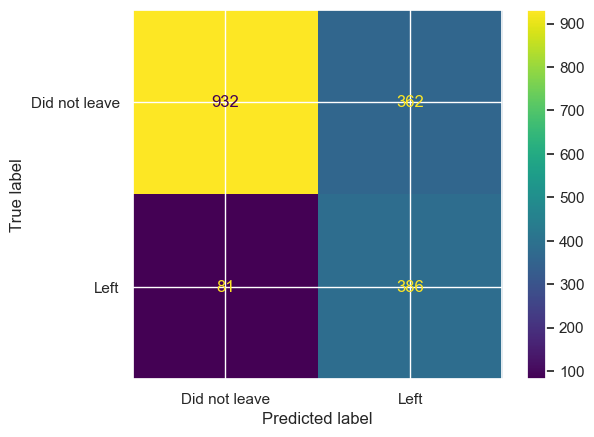

In [47]:
#It does improve our prediction focus on the people who left

prediction_final = clf_xg_final.predict(X_test_transformed)

cm_final = confusion_matrix(y_test, prediction_final)

ConfusionMatrixDisplay(cm_final,
                       display_labels=['Did not leave', 'Left']).plot()

In [48]:
# To get a single tree for understanding further

X_train_transformed_name = pd.get_dummies(X_train)
scaled_features = X_train_transformed_name.copy()

col_names = [col for col in X.columns if X[col].dtypes!='object']
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_features[col_names] = features

In [49]:
clf_xg_single = xgb.XGBClassifier(objective='binary:logistic',
                                 gamma=5,
                                 learning_rate=0.2,
                                 max_depth=4,
                                 reg_lambda=20,
                                 scale_pos_weight=3,
                                 n_estimators=1)

clf_xg_single.fit(scaled_features, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

weight: {'tenure': 2.0, 'MonthlyCharges': 2.0, 'PhoneService_No': 1.0, 'InternetService_Fiber_optic': 1.0, 'OnlineSecurity_No': 1.0, 'TechSupport_No': 1.0, 'Contract_Month-to-month': 1.0, 'Contract_One_year': 1.0, 'PaymentMethod_Electronic_check': 1.0, 'PaymentMethod_Mailed_check': 1.0}
gain: {'tenure': 125.9819564819336, 'MonthlyCharges': 53.38788986206055, 'PhoneService_No': 24.34531021118164, 'InternetService_Fiber_optic': 302.0086669921875, 'OnlineSecurity_No': 17.3548583984375, 'TechSupport_No': 49.60877990722656, 'Contract_Month-to-month': 1840.5963134765625, 'Contract_One_year': 26.75695037841797, 'PaymentMethod_Electronic_check': 26.806167602539062, 'PaymentMethod_Mailed_check': 5.843467712402344}
cover: {'tenure': 672.53125, 'MonthlyCharges': 377.51104736328125, 'PhoneService_No': 252.0900115966797, 'InternetService_Fiber_optic': 1345.0625, 'OnlineSecurity_No': 482.21575927734375, 'TechSupport_No': 257.5810852050781, 'Contract_Month-to-month': 2018.2176513671875, 'Contract_One

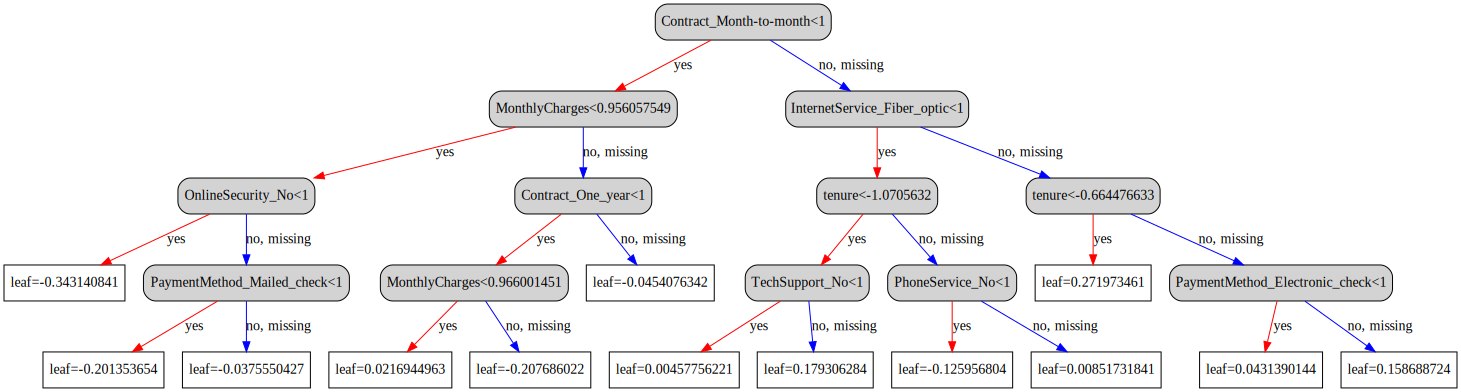

In [50]:
#From first glance, whether the customers have month-to-month contracts seem to be the biggest influence

bst = clf_xg_single.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('{}: {}'.format(importance_type, bst.get_score(importance_type=importance_type)))
    
node_params = {'shape': 'box',
               'style': 'filled, rounded'}
leaf_params = {'shape': 'box',
               'stype': 'filled'}

xgb.to_graphviz(clf_xg_single, size='5,5',
                condition_node_params = node_params,
                leaf_node_params = leaf_params)